In [1]:

from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
import numpy as np
from numpy.fft import fft, ifft
import jax
import time
from jax import vmap, grad, jit, random, lax
from jax import numpy as jnp
from jax.numpy.fft import fft as jfft, ifft as jifft
from util.logger import EventTracker
import matplotlib.pyplot as plt
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion
from itertools import product

MAXITER = 1000

def get_signal(L):
    ## GENERATE SIGNAL
    t = jnp.linspace(0, 2*np.pi, L+1)[:-1]
    #x = jnp.sin(t)
    x = (t < np.pi).astype(float)
    #x = np.random.randn(d)
    return t, x


def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift

def get_mse(x, y):
    return jnp.mean((x - y) ** 2)

def get_snr(x, noise_std):
    return get_mse(x, jnp.mean(x)) / noise_std ** 2

def get_rel_mse(x, y):
    return get_mse(x, y) / get_mse(x, 0.0)

def get_mean_centered_rel_mse(x, y):
    return get_mse(x, y) / get_mse(x, jnp.mean(x))

def get_aligned_rel_mse(x, y):
    y_al = align(jfft(x), jfft(y), y)
    return get_rel_mse(x, y_al) ** 0.5

def em_run(x0, y, noise_std):
    return em_method(jfft(x0), y, noise_std, tol=1e-6, batch_niter=3000, full_niter=MAXITER)

def fpi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means

    return  ifft(fix_point_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=MAXITER)).real

def bsi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_mean, yc_auto_fft, B = invariants_from_data(y, noise_std)
    x, x2, _ = bispectrum_inversion(y_mean, yc_auto_fft, B, tol=1e-6, maxiter=(200, MAXITER))
    if loss_fft(jfft(x), yfft) > loss_fft(jfft(x2), yfft):
        x = x2
    return x

def align_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means
    return  ifft(fix_point_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=MAXITER, project=False)).real


def algn_run(x0, y, noise_std):
    return ifft(align_average(jfft(x0),  fft(y, axis=1))).real

def average_std(M):
    def decorator(func):
        def wrapper(key, *args, **kwargs):
            keys = random.split(key, M)
            vals = jnp.array([func(keys[m], *args, **kwargs) for m in range(M)])
            return {"mean": jnp.mean(vals, axis=0), "std": jnp.std(vals, axis=0)}
        return wrapper
    return decorator

def bisection_search(function, target, a, b, bitol=1e-6, verbose=True, **kwargs):
    ## First, make sure function(a) < target < function(b)
    fa = function(a, **kwargs)
    fb = function(b, **kwargs)
    if fa < target:
        print(f"Error {target} achieved at N={a}. Returning the smaller endpoint.")#, end="\r")
        return a, fa, -1
    if fb > target:
        print(f"Error {target} not achieved at N={b}. Returning the larger endpoint.")#, end="\r")
        return b, fb, -1
    ## Now, do the bisection search
    while b - a > bitol:
        c = int((a + b) / 2)
        fc = function(c, **kwargs)
        if fc > target:
            a = c
            fa = fc
        else:
            b = c
            fb = fc
    c = int((a + b) / 2)
    fc = function(c, **kwargs)
    
    print(f"Found N={c} with error {fc}")
    return c, fc, 0
    
def run_method(key, x, N, noise_std, method, **kwargs):
    y, noise, shift = get_samples(key, x, noise_std, N)
    # If oracle, give access to true shifts
    if method == "oracle":
        oracle = lambda x0, y, noise_std: x + jnp.mean(noise, axis=0)
        val = get_aligned_rel_mse(x, oracle(x, y, noise_std))
    # Otherwise, run the method
    else:
        val = get_aligned_rel_mse(x, method(y[0, :].copy(), y, noise_std, **kwargs))
    return val
    

#@average_std(1)
def run_method_to_eps(key, x, N0, N1, noise_std, eps, method):
    # Run methods
    def method_wrapper(N):
        return run_method(key, x, N, noise_std, method)
    
    N, val, info = bisection_search(method_wrapper, eps, N0, N1, bitol=2)
    return N, val, info

In [2]:

# Main parameters
L = 41
t, x = get_signal(L)

# Compute sample efficiency: error vs (number of samples, noise_std)
num_samples = np.logspace(1, 4, 10, dtype=int)
noise_stds = np.logspace(-3, 1, 40, dtype=float)[::-1]
eps_vals = [1. , 1e-1, 1e-2, 1e-3]
methods = (align_run, fpi_run, bsi_run, em_run, "oracle")
names = ["align", "fpi", "bsi", "em", "oracle"]
data = {name: [] for name in names}


I0000 00:00:1718226725.723862   22506 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:

for name, method in zip(names, methods):
    if name not in ["align", "fpi"]:# "oracle":
        print(f"################ Running {name} ###################")
        for eps in eps_vals:
            N0 = 2
            N1 = 30000
            for std in noise_stds:
                print(f"Running {name} with eps={eps}, std={std}, N in ({N0}, {N1})")#, end="\n")
                N, err, info = run_method_to_eps(random.PRNGKey(0), x, N0, N1, std, eps, method)
                data[name].append((eps, std, err, N))
                if info == 0:
                    N1 = N
        data[name] = np.array(data[name])
        np.save(f"/home/emastr/github/multireference-alignment/data/sample_efficiency_{name}.npy", data[name])
        
    

################ Running bsi ###################
Running bsi with eps=1.0, std=10.0, N in (2, 30000)
Found N=5384 with error 1.028607964515686
Running bsi with eps=1.0, std=7.896522868499725, N in (2, 5384)
Found N=2778 with error 0.7909221649169922
Running bsi with eps=1.0, std=6.235507341273912, N in (2, 2778)
Found N=521 with error 1.3885315656661987
Running bsi with eps=1.0, std=4.923882631706737, N in (2, 521)
Error 1.0 not achieved at N=521. Returning the larger endpoint.
Running bsi with eps=1.0, std=3.888155180308085, N in (2, 521)
Found N=205 with error 0.9589182734489441
Running bsi with eps=1.0, std=3.07029062975785, N in (2, 205)
Found N=26 with error 1.1940112113952637
Running bsi with eps=1.0, std=2.424462017082328, N in (2, 26)
Found N=14 with error 1.000030517578125
Running bsi with eps=1.0, std=1.9144819761699576, N in (2, 14)
Found N=5 with error 1.2371770143508911
Running bsi with eps=1.0, std=1.5117750706156616, N in (2, 5)
Error 1.0 achieved at N=2. Returning the s

2024-06-12 21:36:59.125915: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-06-12 21:36:59.137187: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1h11m2.583529744s

********************************
[Compiling module jit_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Found N=17809 with error 0.0010987351415678859
Running bsi with eps=0.001, std=0.07017038286703826, N in (2, 17809)
Found N=8587 with error 0.0009749926393851638
Running bsi with eps=0.001, std=0.05541020330009492, N in (2, 8587)
Found N=5857 with error 0.0010242339922115207
Running bsi with eps=0.001, std=0.043754793750741844, N in (2, 5857)
Found N=4771 with error 0.000949488952755928
Running bsi with eps=0.001, std=0.03455107294592218, N in (2, 4771)
Found N=1789 with error 0.0012666790280491114
Running bsi with eps=0.001, std=0.02728333376486768, N in (2, 1789)
Found N=1415 with error 0.0010962311644107103
Running bsi with eps=0.001, std=0.021544346900318832, N in (2, 1415)
Found N=905 with error 0.000866197922732681
Running bsi with eps=0.001, std=0.017012542798525893, N in (2, 905)
Found N=679 with error 0.001006547943688929
Running bsi with eps=0.001, std=0.013433993325989001, N in (2, 679)
Found N=376 with error 0.0010342851746827364
Running bsi with eps=0.001, std=0.0106081835

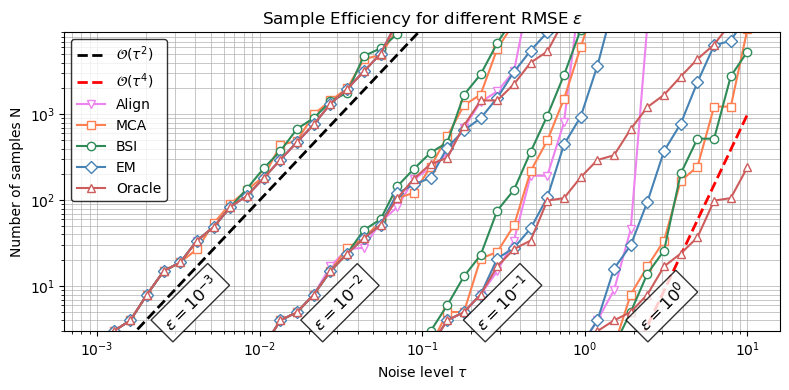

In [4]:
names = ["align", "fpi", "bsi", "em", "oracle"]
colors = ["violet", "coral", "seagreen", "steelblue", "indianred"]
displaynames = ["Align", "MCA", "BSI", "EM", "Oracle"]
styles = ["-v", "-s", "-o", "-D", "-^"]

fig = plt.figure(figsize=(8, 4))
sigma_list = np.logspace(-3, 1, 100)
coefs = [1e6, 0.1]
exp_list = [2, 4]
for i in range(2):
    plt.plot(sigma_list, coefs[i]*sigma_list**exp_list[i], 'k--' if i == 0 else 'r--', linewidth=2, label="$\\mathcal{O}(\\tau^"+f"{exp_list[i]}"+")$")

data = {}
for method, displayname, color, style in zip(names, displaynames, colors, styles):
    #if method != "oracle":
    data[method] = np.load(f"/home/emastr/github/multireference-alignment/data/sample_efficiency_{method}.npy", allow_pickle=True)
    # eps, std, err, M
    for eps in eps_vals:
        data[method] = np.array(data[method])
        idx = (data[method][:, 0] == eps)#*(data[method][:, 3] > 2)#*(data[method][:, 3] < 30000)
        x = data[method][idx, 1]
        y = data[method][idx, 3]
        plt.plot(x, y, style, color=color, label=f"{displayname}" if eps==1.0 else "",  markerfacecolor='white')

# Manual text
#xm = [10e-3, 6e-2, 3e-1, 2]
#ym = [300, 150, 100, 80]
xm = [2.4e-3, 2e-2, 2e-1, 2]
ym = [3, 3, 3, 3, 3]
for i, eps in enumerate(eps_vals[::-1]):
    #plt.text(xm[i], ym[i], "$\epsilon=10^{" + f"{-3+i}" + "}$", fontsize=12, backgroundcolor='white', color='black', bbox=dict(facecolor='white', alpha=0.8))
    plt.text(xm[i], ym[i], "$\epsilon=10^{" + f"{-3+i}" + "}$", fontsize=12, rotation=45, \
        backgroundcolor='white', color='black', bbox=dict(facecolor='white', alpha=0.8))


plt.grid(True, which='both', linewidth=0.5)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Number of samples N")
plt.xlabel("Noise level $\\tau$")
plt.ylim(3, 9000)
plt.legend(loc="upper left")
plt.legend().set_title("Method")
plt.legend().get_frame().set_boxstyle('square')
plt.legend().get_frame().set_linewidth(0.5)
plt.legend().get_frame().set_edgecolor('black')
plt.title("Sample Efficiency for different RMSE $\epsilon$")
plt.tight_layout()

fig.savefig("/home/emastr/github/multireference-alignment/figures/sample_efficiency.pdf", bbox_inches='tight')

In [ ]:
else:
    E_mat = np.load(f"{root}data/efficiency_table.npy")
    N_mat = E_mat[:, :, -2]
    STD_mat = E_mat[:, :, -1]
    
    ### HACK, REMOVE LATER
    num_samples = np.logspace(1, 4, 10, dtype=int)
    noise_stds = np.logspace(-3, 1, 10, dtype=float)
    methods = (fpi_run, bsi_run, em_run)
    names = ["Fix Point", "Bispectrum", "EM", "Oracle"]
    N_mat, STD_mat = np.meshgrid(num_samples, noise_stds, indexing='ij')
    ############
    
    
    fig = plt.figure(figsize=(15, 5))
    #plt.pcolormesh(N_mat, STD_mat, E_mat[:, :, 2], norm=LogNorm())
    for i in range(len(names)):
        plt.subplot(1, len(names), i+1)
        plt.title(f"Sample efficiency {names[i]}")
        
        # contour begin
        levels = [float(r) for r in [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]]
        strings = ['$10^{' + f'{i}' + '}$' for i in [-4, -3, -2, -1, 0, 1]]
        fmt = {l: s for s, l in zip(strings, levels)}
        CS = plt.contour(STD_mat, N_mat, E_mat[:, :, i], levels=levels, norm=LogNorm())
        for j, curve in enumerate(CS.allsegs):
            curve = curve[0]
            print(curve)
            if len(curve) > 0:
                x = curve[len(curve)//2][0] #(curve[0][0]*curve[-1][0])**0.5
                y  = curve[len(curve)//2][1]#(curve[0][1]*curve[-1][1])**0.5
                plt.text(x, y, strings[j], backgroundcolor="white")
        plt.grid(True, which='both', linewidth=0.5)
        #lbls = plt.gca().clabel(CS, inline=True, fontsize=10, fmt=fmt, inline_spacing=0.01)
        #for lbl in lbls:
            #lbl.set_rotation(0)
        ### Contour end
        plt.yscale("log")
        plt.xscale("log")
        plt.ylabel("Number of samples N")
        plt.xlabel("Noise level $\sigma$")
        plt.ylim([N_mat.min(), N_mat.max()])
        plt.xlim([STD_mat.min(), STD_mat.max()])
    #plt.colorbar()
    plt.tight_layout()
    fig.savefig(f"{root}data/efficiency2.png")
    
    
    
    
    fig2 = plt.figure(2)#figsize=(15, 5))
    ax2 = plt.gca()
    fig = plt.figure(3)
    ax = plt.gca()
    colors = ["coral", "seagreen", "steelblue", "indianred"]
    styles = ["-s", "-o", "-D", "-^"]
    #plt.pcolormesh(N_mat, STD_mat, E_mat[:, :, 2], norm=LogNorm())
    
    plt.title(f"Sample efficiency at different error levels $\epsilon$")
    for i in range(len(names)):
        
        # contour begin
        #levels = [float(r) for r in [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]]
        levels = [float(r) for r in [1e-4, 1e-3, 1e-2]]
        strings = ['$\epsilon = 10^{' + f'{i}' + '}$' for i in [-4, -3, -2, -1, 0, 1]]
        fmt = {l: s for s, l in zip(strings, levels)}
        CS = ax2.contour(STD_mat, N_mat, E_mat[:, :, i], levels=levels, norm=LogNorm(), colors=colors[i])
        #plt.plot([], [], color=colors[i], label=names[i])

        for j, curve in enumerate(CS.allsegs):
            curve = curve[0]
            x = [curve[i][0] for i in range(len(curve))]
            y = [curve[i][1] for i in range(len(curve))]
            if j != 0:
                ax.plot(x, y, styles[i], color=colors[i], markerfacecolor='white')
            else:
                ax.plot(x, y, styles[i], color=colors[i], label=names[i], markerfacecolor='white')
    
    for j, curve in enumerate(CS.allsegs):
        curve = curve[0]
        print(curve)
        if len(curve) > 0:
            x = 0.7*curve[len(curve)//2][0] #(curve[0][0]*curve[-1][0])**0.5
            y  = curve[len(curve)//2][1]#(curve[0][1]*curve[-1][1])**0.5
            plt.text(x, y, strings[j], backgroundcolor="white")
            
    ss = STD_mat[0, :]
    plt.plot(ss, [(2000*s)**2 for s in ss], '--', color='black', label='$O(N^2)$')
    plt.plot(ss, [(100*s)**3 for s in ss], '--', color='black', label='$O(N^3)$')
    plt.legend(loc="lower right")
    plt.grid(True, which='both', linewidth=0.5)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("Number of samples N")
    plt.xlabel("Noise level $\sigma$")
    plt.ylim([N_mat.min(), N_mat.max()])
    #plt.xlim([STD_mat.min(), STD_mat.max()])
    plt.xlim([STD_mat.min(), 1.])
    #plt.colorbar()
    plt.tight_layout()
    fig.savefig(f"{root}data/efficiency3.png")


SyntaxError: invalid syntax (1516248791.py, line 1)